In [1]:
import numpy as np
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12 #x轴的字体大小
plt.rcParams['ytick.labelsize'] = 12 #y轴的字体大小
import warnings
warnings.filterwarnings('ignore') 
np.random.seed(42) 

### 数据集读取
- Mnist数据是图像数据：(28,28,1)的灰度图

In [2]:
from scipy.io import loadmat 
mnist = loadmat('./mnist-original.mat') # .mat是matlab的数据储存格式
mnist


{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar 30 03:19:02 2014',
 '__version__': '1.0',
 '__globals__': [],
 'mldata_descr_ordering': array([[array(['label'], dtype='<U5'), array(['data'], dtype='<U4')]],
       dtype=object),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'label': array([[0., 0., 0., ..., 9., 9., 9.]])}

In [3]:
X, y = mnist["data"].T, mnist["label"].T #转置
X.shape #X的样本量是70000，因为Mnist数据是图像数据：(28,28,1)的灰度图，所以特征是28*28*1 = 784。

(70000, 784)

In [4]:
y.shape #如下列第一排标签是0，第二排标签是1，所以70000个样本的标签有70000个，即y的shape值是70000行1列。

(70000, 1)

![title](./img3/9.png)

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] 
X_train.shape,X_test.shape,y_train.shape,y_test.shape #前60000个样本作为训练集合，之后的数据作为测试

((60000, 784), (10000, 784), (60000, 1), (10000, 1))

In [6]:
# 洗牌操作
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index] 

In [7]:
shuffle_index #可以看到索引是打乱的

array([12628, 37730, 39991, ...,   860, 15795, 56422])

### 交叉验证

![title](./img3/5.png)

![title](./img3/7.png)

In [8]:
y_train_5 = (y_train==5) #目的：训练集中把标签为5的y甄别出来
y_test_5 = (y_test==5) 

In [9]:
y_train_5 = y_train_5.flatten()#flatten()将数组拉直（多维数组降为一维数组）
y_test_5 = y_test_5.flatten()
y_train_5[:10]


array([False, False, False, False, False, False, False, False, False,
        True])

In [10]:
from sklearn.linear_model import SGDClassifier #sklearn工具包下的线性模型，在该模型下导入梯度下降算法的分类器

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train,y_train_5) 

SGDClassifier(max_iter=5, random_state=42)

In [11]:
sgd_clf.predict([X[35000]]) #预测函数

array([ True])

In [12]:
y[35000] #真实的标签，看一下与上述判断是不是5的结果做对比。可以看到对应于样本[X[35000]]，真实的标签确实是5.

array([5.])

In [13]:
from sklearn.model_selection import cross_val_score #做交叉验证需要cross_val_score方法，这句的调用来自下方网址：
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')#参数见官网下cross_val_score方法的参数说明

#因为选的是3折，所有输出的是三个验证集的分类正确率。可以做这三个的平均当作一个指标来看。

array([0.96225, 0.9645 , 0.94765])

In [14]:
X_train.shape

(60000, 784)

In [15]:
y_train_5.shape

(60000,)

In [16]:
from sklearn.model_selection import StratifiedKFold #手动把数据分成n份再编写代码做交叉验证
from sklearn.base import clone 

skflods = StratifiedKFold(n_splits=3,shuffle=True,random_state=42)#n_splits=3：把数据集切分为3个，random_state=42设置随机种子

for train_index,test_index in skflods.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf) #克隆模型
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds) 
    y_pred = clone_clf.predict(X_test_folds) #在验证集中用样本X_test_folds做预测
    n_correct = sum(y_pred == y_test_folds) 
    print(n_correct/len(y_pred)) #用正确的个数/总个数作为验证集下的准确率

0.9686
0.96205
0.9668


### Confusion Matrix-混淆矩阵

![title](./img3/8.png)

In [17]:
from sklearn.model_selection import cross_val_predict # cross_val_predict：Generate cross-validated estimates for each input data point
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)# y_train_pred其实是三次交叉验证的预测值的集合

In [18]:
y_train_pred.shape #这60000个预测值相当于3次交叉验证，每次预测的2万标签的结果结合

(60000,)

In [19]:
X_train.shape 

(60000, 784)

In [20]:
from sklearn.metrics import confusion_matrix #confusion_matrix： Compute confusion matrix to evaluate the accuracy of a classification.
confusion_matrix(y_train_5,y_train_pred) #展示混淆矩阵

array([[53417,  1162],
       [ 1350,  4071]], dtype=int64)

negative class  [[ **true negatives** , **false positives** ],
 
positive class  [ **false negatives** , **true positives** ]]

* true negatives:  53,417个数据被正确的分为非5类别
* false positives：1162张被错误的分为5类别

* false negatives：1350张错误的分为非5类别
* true positives： 4071张被正确的分为5类别

一个完美的分类器应该只有**true positives** 和 **true negatives**, 即主对角线元素不为0，其余元素为0

### Precision and Recall


### **$ precision = \frac {TP} {TP + FP} $**


### **$ recall = \frac {TP} {TP + FN} $**

![title](./img3/1.png)

In [21]:
from sklearn.metrics import precision_score,recall_score #sklearn中求精度precision和召回率recall的工具
precision_score(y_train_5,y_train_pred)

0.7779476399770686

In [22]:
recall_score(y_train_5,y_train_pred)

0.7509684560044272

将**Precision** 和 **Recall**结合到一个称为**F1 score** 的指标,调和平均值给予低值更多权重。 因此，如果召回和精确度都很高，分类器将获得高F 1分数。

### $ F_1  = $ $2\over {1\over precision}+{1\over recall} $ $=$ $2×$ $precision×recall\over precision+recall $ $=$ $TP\over {TP}+{FN + FP\over 2}$

In [23]:
from sklearn.metrics import f1_score #sklearn中求F1 score的指标，即调和平均数
f1_score(y_train_5,y_train_pred)

0.7642200112633752

### 阈值对结果的影响

![title](./img3/2.png)

In [24]:
y_scores = sgd_clf.decision_function([X[35000]]) #decision_function：Predict confidence scores for samples.
# The confidence score for a sample is proportional to the signed distance of that sample to the hyperplane.
y_scores

array([130851.69291613])

In [25]:
t = 50000 
y_pred = (y_scores > t)
y_pred

array([ True])

Scikit-Learn不允许直接设置阈值，但它可以得到决策分数，调用其**decision_function（）**方法，而不是调用分类器的**predict（）**方法，该方法返回每个实例的分数，然后使用想要的**阈值**根据这些分数进行预测：

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function") 
y_scores.shape

(60000,)

In [27]:
y_scores[:10] 

array([ -344482.72660078, -2207948.71399372,  -747234.78009357,
        -484767.20562804,  -468335.78059607,  -408939.5646945 ,
        -605512.48296772,  -259980.56489848,  -310147.38164882,
        -387143.33685258])

### ROC curves
**receiver operating characteristic (ROC)** 曲线是二元分类中的常用评估方法
* 它与精确度/召回曲线非常相似，但ROC曲线不是绘制精确度与召回率，而是绘制**true positive rate(TPR)** 与**false positive rate(FPR)** 

* 要绘制ROC曲线，首先需要使用**roc_curve（）**函数计算各种阈值的**TPR和FPR**：

TPR = TP / (TP + FN) (Recall)

FPR = FP / (FP + TN)

In [28]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores) #计算得到不同阈值下的fpr和tpr，由此绘制下方图形。

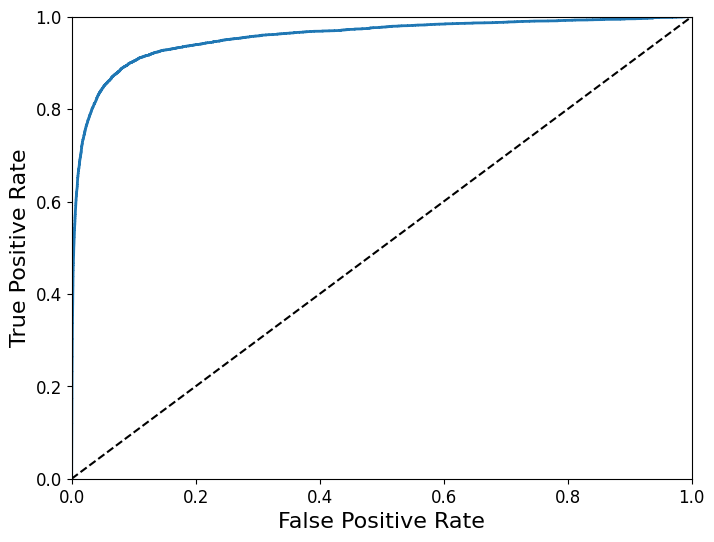

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

**虚线表示纯随机分类器的ROC曲线**; 一个好的分类器尽可能远离该线（朝左上角）。

比较分类器的一种方法是测量曲线下面积（AUC）。完美分类器的ROC AUC**等于1**，而纯随机分类器的ROC AUC**等于0.5**。 Scikit-Learn提供了计算ROC AUC的函数：

In [30]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9562435587387078

思考题：

In [ ]:
1下述代码的含义：

from sklearn.model_selection import cross_val_score 
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

In [ ]:
交叉验证方法：

from sklearn.model_selection import cross_val_score #做交叉验证需要cross_val_score方法
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')
#第1参数：模型算法；第2参数：输入的数组array结构的x样本；第3参数：输入的数组array结构的y标签；第4参数：交叉验证的折数，3代表数据集切成3份；
#第5参数：scoring代表得分项，即用它进行模型评估。

In [ ]:
2下述代码的含义：

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [ ]:
n折交叉验证预测：

from sklearn.model_selection import cross_val_predict
>>>y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)#做预测，由模型sgd_clf及3折交叉验证，样本X_train得到预测的结果
# 这样，y_train_pred其实是三次交叉验证的预测值的集合

3混淆矩阵 精度和召回率 调和平均数 ROC曲线 ROC曲线下方面积计算如何实现代码？它们的含义是什么？

In [ ]:
混淆矩阵计算：

from sklearn.metrics import confusion_matrix

精度和召回率计算：

from sklearn.metrics import precision_score,recall_score 
precision_score(y_train_5,y_train_pred) #由预测值y_train_pred对比真实值y_train_5，得精度。
recall_score(y_train_5,y_train_pred) #由预测值y_train_pred对比真实值y_train_5，得召回率。


调和平均数计算：

from sklearn.metrics import f1_score #求F1 score的指标，即调和平均数
f1_score(y_train_5,y_train_pred) #由预测值y_train_pred对比真实值y_train_5，得调和平均数。

ROC曲线计算：

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores) #计算得到不同阈值下的FPR和TPR，由此绘制ROC曲线图形。

ROC曲线下方面积：

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

4如何拼接数据（两个矩阵拼接在一起）？

In [ ]:
拼接数据（按列及按行拼接数据的方法）：

第一种方法：利用 np.c_

X_b = np.c_[np.ones((100,1)),X] #对于y=theta_0 + theta_1*x_1改写成y=theta_0*x_0 + theta_1*x_1,其中x_0=1.
#np.c_代表竖着拼接，因为上述X.shape可以看到X是列向量，所以这里再X之前竖着按列再拼接一列1即可。（如果是横着拼接的话，代码为np.r_）

第二种方法：利用 np.hstack

data_processed = np.hstack((np.ones((num_examples, 1)), data_processed)) # np.hstack起到拼接的作用
#样本的所有特征基础上加一列1的方法

5给定一个向量，找到最小值和最大值，按照最小值和最大值的距离，等距分割100个点，如何实现？

In [ ]:
一定取值范围下等距分割的方法：

x_predictions = np.linspace(x.min(),x.max(),100).reshape(100,1)


#所以这里linspace中以x中的最小值和最大值为起始点和终点，等距分100个点


In [ ]:
6假设有 100 张照片，其中，猫的照片有 60 张，狗的照片是 40 张。
识别结果：TP=40，FN=20，FP=10，TN=30，则可以得到：。
A.Accuracy=0.8
B.Precision=0.8
C.Recall=0.8
D.以上都不对

In [ ]:
B

In [ ]:
7以下关于训练集、验证集和测试集说法不正确的是
A.测试集是纯粹是用于测试模型泛化能力
B.训练集是用来训练以及评估模型性能
C.验证集用于调整模型参数
D.以上说法都不对


In [ ]:
B

In [ ]:
8一般来说，在机器学习中，用计算机处理一幅的图像，维度是：
A.上万维
B.二维
C.三维
D.一维


In [ ]:
A

In [ ]:
9下列对混淆矩阵说法正确的是（）。
A.FP：将负样本识别为正样本的数目（概率）
B.FN：将正样本识别为负样本的数目（概率）
C.TP：将正样本识别为正样本的数目（概率）
D.TN：将负样本识别为正样本的数目（概率）


In [ ]:
A、B、C

In [ ]:
10利用ROC曲线来度量分类模型性能是，曲线越靠近左上角，则模型分类性能越好？

In [ ]:
对